<a href="https://colab.research.google.com/github/mehrdadzaa/Mehrdadza/blob/main/Simulation_Money_Circulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Agents= 3000   #Steps= 40   %interacting= 0.5
Current Time: 20:59:35.347290
X0 generated Time: 20:59:35.350821
F0 generated Time: 20:59:36.205372
Ft generated Time: 20:59:38.639685
Xt generated Time: 20:59:38.892639
Xe generated Time: 20:59:39.068107


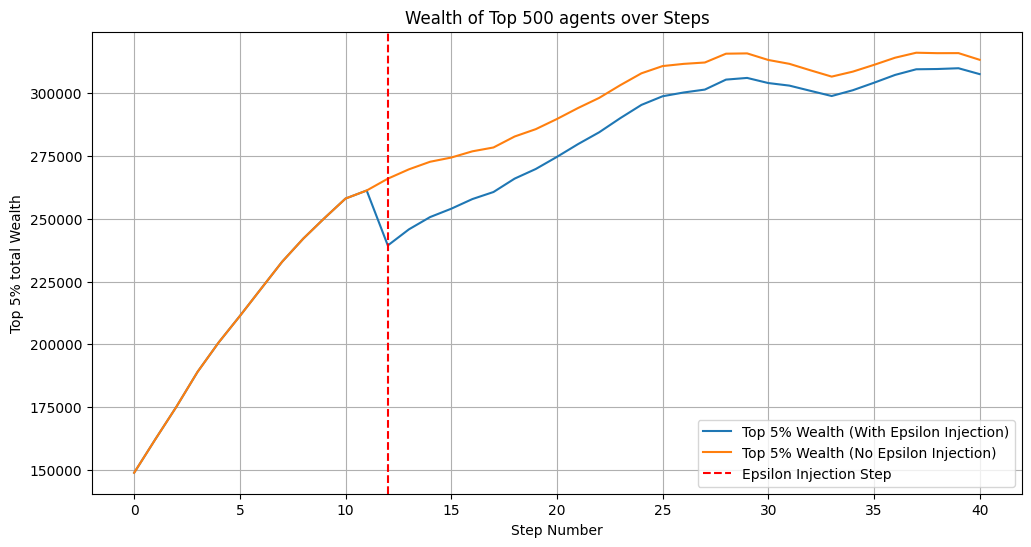

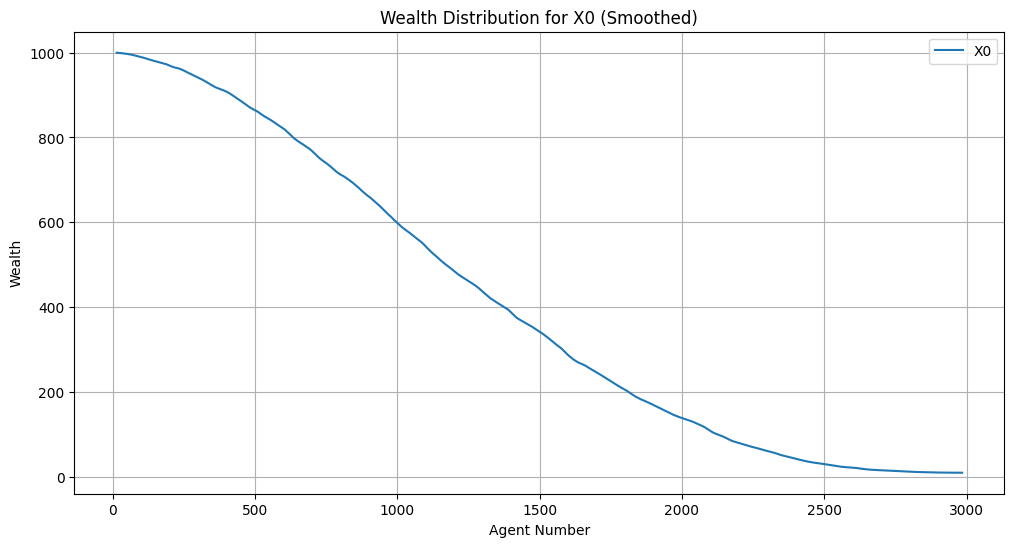

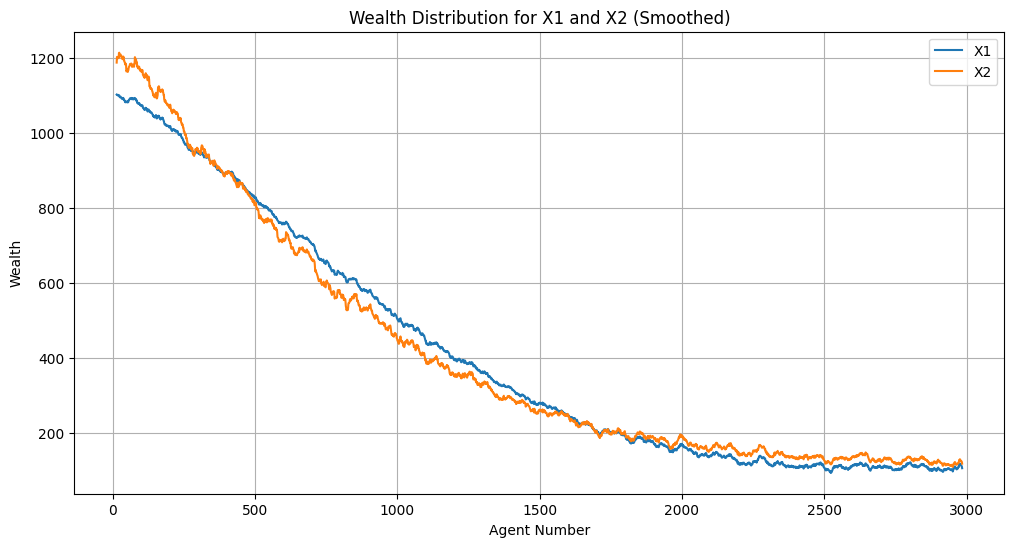

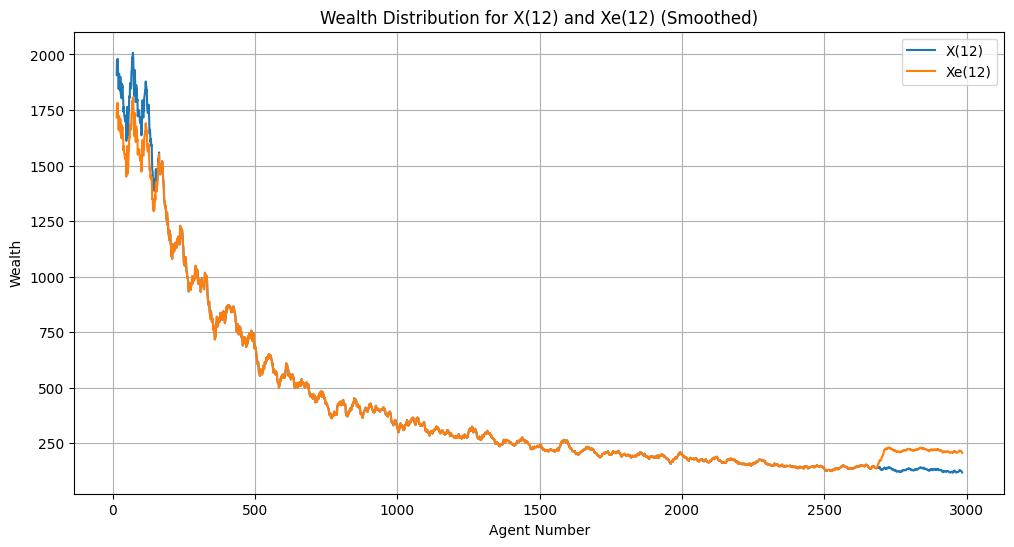

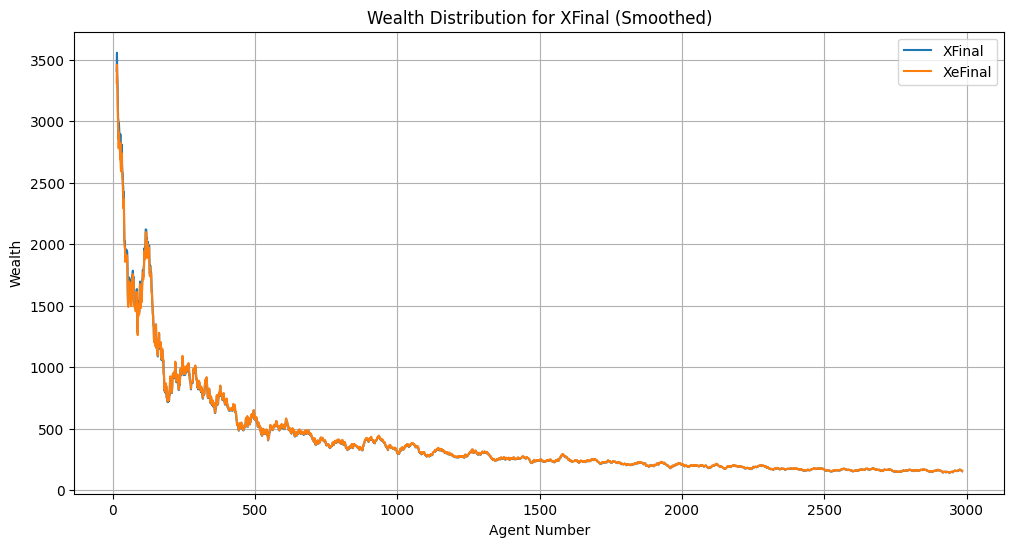

{12: 0.9000000000000001, 18: 0.9406793135439612, 24: 0.9591453104427394, 36: 0.9781779610187583}


<Figure size 1200x600 with 0 Axes>

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from scipy.stats import beta
from datetime import datetime

# Function to generate initial wealth matrix
def generate_initial_wealth_matrix(n, seed=42):
    np.random.seed(seed)
    alpha, beta_param = 0.4, 0.6  # Parameters to control the shape of the distribution
    lower_bound = 10
    upper_bound = 1000

    initial_wealth = beta.rvs(alpha, beta_param, size=n)
    initial_wealth = lower_bound + initial_wealth * (upper_bound - lower_bound)  # Scale to the desired range

    df = pd.DataFrame(initial_wealth, columns=['Initial Wealth'])
    df_sorted = df.sort_values(by='Initial Wealth', ascending=False).reset_index(drop=True)
    X0 = df_sorted.values.flatten()  # Flatten to get a 1D array

    return X0

# Function to generate F0 matrix
def generate_F0(n, x, tc, bc, seed=42):
    np.random.seed(seed)  # Set random seed for reproducibility
    F = np.zeros((n, n))  # Initialize an n x n matrix with zeros
    wealth_fractions = np.sort(np.random.rand(n))[::-1]  # Generate sorted random wealth fractions in descending order

    for j in range(n):
        interacting = int(n * intract / 100)  # Calculate the number of interacting agents

        if (interacting > 0):
            interacting_indices = np.random.choice(n, interacting, replace=False)  # Randomly select interacting agents
            random_fractions = np.random.rand(interacting)  # Generate random fractions for interacting agents
            random_fractions /= random_fractions.sum()  # Normalize fractions to sum to 1
            random_fractions *= (1 - wealth_fractions[j])  # Scale by remaining wealth
            F[interacting_indices, j] = random_fractions  # Assign fractions to the selected indices

        F[j, j] = wealth_fractions[j]  # Assign wealth fraction to the diagonal element

    # Determine the top 2% of rows based on wealth fractions
    top_10_percent_indices = np.arange(int(n * 0.05))

    for i in top_10_percent_indices:
        zero_indices = np.where(F[i] == 0)[0]  # Find indices of zero elements
        num_to_change = int(len(zero_indices) * tc / 100)  # Calculate the number of elements to change

        if num_to_change > 0:
            elements_to_change = np.random.choice(zero_indices, num_to_change, replace=False)  # Select elements to change
            F[i, elements_to_change] = np.random.rand(num_to_change) / n  # Assign random values between 0 and 1/n

     # Determine the bottom 10% of rows based on wealth fractions
    bottom_10_percent_indices = np.arange(int(n * 0.9), n)

    for i in bottom_10_percent_indices:
        non_zero_indices = np.where((F[i] != 0) & (np.arange(n) != i))[0]  # Find indices of non-zero elements excluding diagonal
        num_to_zero = int(len(non_zero_indices) * bc / 100)  # Calculate the number of elements to set to zero

        if num_to_zero > 0:
            elements_to_zero = np.random.choice(non_zero_indices, num_to_zero, replace=False)  # Select elements to set to zero
            F[i, elements_to_zero] = 0  # Set selected elements to zero

    # Normalize each column to ensure the final matrix is column stochastic
    for j in range(n):
        F[:, j] /= F[:, j].sum()  # Normalize the column to sum to 1

    return F

# Function to generate Ft matrix
def generate_Ft(F_prev, a, b, c, step_seed):
    np.random.seed(step_seed)
    n = F_prev.shape[0]
    F_new = F_prev.copy()
    num_columns_to_modify = int(a * n / 100)
    columns_to_modify = np.random.choice(n, num_columns_to_modify, replace=False)

    for j in columns_to_modify:
        ajj = F_prev[j, j]
        num_elements_to_modify = int(b * n / 100)
        elements_to_modify = np.random.choice(n, num_elements_to_modify, replace=False)

        for i in elements_to_modify:
            random_change = np.random.uniform(-c / 100, c / 100)
            F_new[i, j] = min(max(F_new[i, j] + random_change, 0), 1)

        F_new[:, j] /= F_new[:, j].sum()

    return F_new

# Function to generate all Ft matrices
def generate_all_Ft(F0, S, a, b, c, seed=42):
    F_matrices = [F0]
    for t in range(1, S + 1):
        step_seed = seed + t
        F_new = generate_Ft(F_matrices[-1], a, b, c, step_seed)
        F_matrices.append(F_new)
    return F_matrices

# Function to generate wealth matrices X(t)
def generate_wealth_matrices(X0, F_matrices):
    X_matrices = [X0]
    for t in range(1, len(F_matrices)):
        X_new = np.dot(F_matrices[t-1], X_matrices[-1])
        X_matrices.append(X_new)
    return X_matrices

def calculate_top_bottom_wealth(X_matrices, top_percent=5, bottom_percent=10):
    results = []  # Initialize an empty list to store the results

    for t, X in enumerate(X_matrices):  # Loop through each matrix in X_matrices
        num_agents = len(X)  # Get the number of agents (rows in X)
        top_k = int(np.ceil(top_percent / 100 * num_agents))  # Calculate the number of elements in the top_percent
        bottom_k = int(np.ceil(bottom_percent / 100 * num_agents))  # Calculate the number of elements in the bottom_percent

        top_wealth = np.sum(X[:top_k])  # Calculate the total wealth of the top_k rows
        bottom_wealth = np.sum(X[-bottom_k:])  # Calculate the total wealth of the bottom_k rows
        total_wealth = np.sum(X)  # Calculate the total wealth of all rows

        results.append((t, top_wealth, bottom_wealth, total_wealth))  # Append the results as a tuple

    return results


# Function to apply epsilon injection at step 12
def apply_epsilon_injection(X, top_percent=5, bottom_percent=10, injection_percent=10):
    num_agents = len(X)  # Get the number of agents (rows in X)

    top_k = int(np.ceil(top_percent / 100 * num_agents))  # Calculate the number of elements in the top_percent
    bottom_k = int(np.ceil(bottom_percent / 100 * num_agents))  # Calculate the number of elements in the bottom_percent

    top_indices = np.arange(top_k)  # Select the indices of the top_k agents (first top_k rows)
    bottom_indices = np.arange(num_agents - bottom_k, num_agents)  # Select the indices of the bottom_k agents (last bottom_k rows)

    total_injection = np.sum(X[:top_k]) * (injection_percent / 100)  # Calculate the total amount to inject by taking injection_percent% of the wealth from the top_k agents

    Xe = X.copy().astype(float)  # Create a copy of X as float to avoid casting issues
    Xe[top_indices] = Xe[top_indices] * (1 - (injection_percent / 100))  # Decrease the wealth of the top_k agents by injection_percent%

    injection_per_agent = total_injection / bottom_k  # Distribute the total_injection amount equally among the bottom_k agents
    Xe[bottom_indices] += injection_per_agent

    return Xe  # Return the modified array

# Example usage
n = 3000  # Number of agents
intract = 0.5  # Percentage of interacting agents
S = 40  # Number of steps to generate Ft matrices
a = 2  # Percentage of columns to modify
b = 2  # Percentage of elements to modify
c = 5  # Maximum percentage change to elements
tc = 0  # Percentage of non-zero elements to modify in top 10% rows
bc = 0  # Percentage of non-zero elements to set to zero in bottom 10% rows

#Scenarios: various x valuse: 50%, 0.5%, 0.005% (low connectivity to high connectivity)

print ("#Agents=", n, "  #Steps=", S, "  %interacting=", intract)
current_time = datetime.now().time()
print("Current Time:", current_time)

# Seed values
initial_wealth_seed = 40
F0_seed = 42
Ft_seed_base = 44

# Generate the initial wealth matrix X(0)
X0 = generate_initial_wealth_matrix(n, initial_wealth_seed)
current_time = datetime.now().time()
print("X0 generated Time:", current_time)

# Generate the F(0) money transaction matrix
F0 = generate_F0(n, intract, tc, bc)
current_time = datetime.now().time()
print("F0 generated Time:", current_time)

# Generate all F(t) matrices
F_matrices = generate_all_Ft(F0, S, a, b, c, Ft_seed_base)
current_time = datetime.now().time()
print("Ft generated Time:", current_time)

# Generate wealth matrices
X_matrices = generate_wealth_matrices(X0, F_matrices)
current_time = datetime.now().time()
print("Xt generated Time:", current_time)

# Apply epsilon injection at step 12 to get Xe(12)
X12 = X_matrices[12]
Xe12 = apply_epsilon_injection(X12)

# Generate wealth matrices for the scenario with epsilon injection from Xe(12) onward
X_matrices_with_injection = X_matrices[:12] + [Xe12] + generate_wealth_matrices(Xe12, F_matrices[12:])[1:]

current_time = datetime.now().time()
print("Xe generated Time:", current_time)

# Calculate total wealth of top 10%, bottom 10% agents, and total wealth for both scenarios
top_bottom_wealth_with_injection = calculate_top_bottom_wealth(X_matrices_with_injection)

# Convert results to DataFrame for better readability
df_results_with_injection = pd.DataFrame(top_bottom_wealth_with_injection, columns=['Step Number', 'Top 5% Wealth (With Epsilon Injection)', 'Bottom 10% Wealth (With Epsilon Injection)', 'Total Wealth (With Epsilon Injection)'])

# Display the results
df_results_with_injection


# Calculate total wealth of top 10%, bottom 10% agents, and total wealth for both scenarios
top_bottom_wealth_no_injection = calculate_top_bottom_wealth(X_matrices)
top_bottom_wealth_with_injection = calculate_top_bottom_wealth(X_matrices_with_injection)

# Convert results to DataFrames for better readability
df_results_no_injection = pd.DataFrame(top_bottom_wealth_no_injection, columns=['Step Number', 'Top 5% Wealth (No Epsilon Injection)', 'Bottom 10% Wealth (No Epsilon Injection)', 'Total Wealth (No Epsilon Injection)'])
df_results_with_injection = pd.DataFrame(top_bottom_wealth_with_injection, columns=['Step Number', 'Top 5% Wealth (With Epsilon Injection)', 'Bottom 10% Wealth (With Epsilon Injection)', 'Total Wealth (With Epsilon Injection)'])

# Merge the results into a single DataFrame
df_results_merged = pd.merge(df_results_no_injection, df_results_with_injection, on='Step Number')

# # Save the merged results table to an Excel file
# df_results_merged.drop(columns=['Total Wealth (No Epsilon Injection)', 'Total Wealth (With Epsilon Injection)'], inplace=True)
# df_results_merged.to_excel('wealth_distribution.xlsx', index=False)



# Plot the results for top 5% wealth in one graph
plt.figure(figsize=(12, 6))
plt.plot(df_results_merged['Step Number'], df_results_merged['Top 5% Wealth (With Epsilon Injection)'], label='Top 5% Wealth (With Epsilon Injection)')
plt.plot(df_results_merged['Step Number'], df_results_merged['Top 5% Wealth (No Epsilon Injection)'], label='Top 5% Wealth (No Epsilon Injection)')
plt.axvline(x=12, color='r', linestyle='--', label='Epsilon Injection Step')
plt.xlabel('Step Number')
plt.ylabel('Top 5% total Wealth')
plt.title('Wealth of Top 500 agents over Steps')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the results for bottom 10% wealth in another graph
# plt.figure(figsize=(12, 6))
# plt.plot(df_results_merged['Step Number'], df_results_merged['Bottom 10% Wealth (With Epsilon Injection)'], label='Bottom 10% Wealth (With Epsilon Injection)')
# plt.plot(df_results_merged['Step Number'], df_results_merged['Bottom 10% Wealth (No Epsilon Injection)'], label='Bottom 10% Wealth (No Epsilon Injection)')
# plt.axvline(x=12, color='r', linestyle='--', label='Epsilon Injection Step')
# plt.xlabel('Step Number')
# plt.ylabel('Bottom 10% total Wealth')
# plt.title('Wealth of Bottom 10% over Steps')
# plt.legend()
# plt.grid(True)
# plt.show()


# Plotting the specified wealth matrices with moving average

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
window_size = 30  # Adjust the window size as needed for smoothing

plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[0].flatten(), window_size), label='X0', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for X0 (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[1].flatten(), window_size), label='X1', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[2].flatten(), window_size), label='X2', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for X1 and X2 (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()


# Plot X(12) and Xe(12)
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X12.flatten(), window_size), label='X(12)', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(Xe12.flatten(), window_size), label='Xe(12)', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for X(12) and Xe(12) (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

# Plot X(final) and Xe(final)
plt.figure(figsize=(12, 6))
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[S-1].flatten(), window_size), label='XFinal', linestyle='-')
plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[S-1].flatten(), window_size), label='XeFinal', linestyle='-')
plt.xlabel('Agent Number')
plt.ylabel('Wealth')
plt.title('Wealth Distribution for XFinal (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()


# Ensure n is at least 1000 for slicing
num_agents = min(n, 500)

# plt.figure(figsize=(12, 6))
# plt.plot(
#     moving_average(range(num_agents), window_size),
#     moving_average(X_matrices[S-1].flatten()[:num_agents], window_size),
#     label='XFinal',
#     linestyle='-'
# )
# plt.plot(
#     moving_average(range(num_agents), window_size),
#     moving_average(X_matrices_with_injection[S-1].flatten()[:num_agents], window_size),
#     label='XeFinal',
#     linestyle='-'
# )
# plt.xlabel('Agent Number')
# plt.ylabel('Wealth')
# plt.title('Wealth Distribution for X(f) and Xe(f) (Smoothed)')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot X(S-1) - Xe(S-1)
plt.figure(figsize=(12, 6))
#plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[S-1].flatten(), window_size), label='X(Final)', linestyle='-')
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices[12].flatten(), window_size), label='X(12)', linestyle='-')
#plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[12].flatten()-X_matrices[12].flatten(), window_size), label='Xe(12)-X(12)', linestyle='-')
# plt.plot(moving_average(range(n), window_size), moving_average(X_matrices_with_injection[S-1].flatten()-X_matrices[S-1].flatten(), window_size), label='Xe(final)-X(final)', linestyle='-')

# plt.xlabel('Agent Number')
# plt.ylabel('Wealth difference')
# plt.title('Xe(t)-X(t) at step 40 for each agent(Smoothed)')
# plt.legend()
# plt.grid(True)
# plt.show()


# Calculate the ratio of the wealth of the first 10% rows of Xe to the wealth of the first 10% rows of X for all time steps
# Extract the top 10% wealth for both scenarios from the merged DataFrame
top_wealth_no_injection = df_results_merged['Top 5% Wealth (No Epsilon Injection)']
top_wealth_with_injection = df_results_merged['Top 5% Wealth (With Epsilon Injection)']

# Calculate the ratio of top 10% wealth with injection to top 10% wealth without injection
wealth_ratios = top_wealth_with_injection / top_wealth_no_injection

# # Plot the wealth ratios
# plt.figure(figsize=(12, 6))
# plt.plot(df_results_merged['Step Number'], wealth_ratios, marker='o', linestyle='-', color='b', label='Wealth Ratio (Top 5% Xe / Top 5% X)')
# plt.axvline(x=12, color='r', linestyle='--', label='Epsilon Injection Step')
# plt.xlabel('Step Number')
# plt.ylabel('Wealth Ratio (Top 500 Xe / Top 500 X)')
# plt.title(f'connectivity = {intract:.3f}')
# plt.legend()
# plt.grid(True)
# plt.show()

# Calculate the ratio of the wealth of the first 10% rows of Xe to the wealth of the first 10% rows of X for steps 12, 20, 30, 40
steps_to_check = [12, 18, 24, 36]
wealth_ratios = {}

for step in steps_to_check:
    wealth_ratios[step] = top_wealth_with_injection[step] / top_wealth_no_injection[step]

# Display the wealth_ratios
print(wealth_ratios)
